# Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Cleaning the Data](#cleaning)
- [Part II - Probability](#probability)
- [Part III - A/B Test](#ab_test)
- [Part IV - Logistic Regression](#regression)


<a id='intro'></a>
### Introduction

The goal of this project is to perform A/B testing on conversion data run ny an e-commerce website. The company wishes to know if they should implement their new web page or keep their old one. 

In [277]:
# Importing Libraries
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

We first need to read in the data provided by the e-commerce website and then take a look at the size and format of our dataset.

In [278]:
# Reading in the ab data
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Total number of rows in the dataset is 294478.

In [279]:
df.shape[0]

294478

The number of unique users in the dataset 290584.

In [280]:
df.user_id.nunique()

290584

The proportion of users converted regardless of page is approximately 12%.

In [281]:
(df[df["converted"] == 1]['user_id'].count())/df.shape[0]

0.11965919355605512

<a id='cleaning'></a>
### Part I - Cleaning the Data

There are no missing values in the dataset.

In [282]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


Check to see if the "group" and "landing_page" columns line up correctly. There are 3893 rows that are mismatched.

In [283]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False]["user_id"].count()

3893

In [284]:
df[((df['group'] == 'control') == (df['landing_page'] == 'old_page')) == False]["user_id"].count()

3893

Drop mismatched results from the dataset. 

In [285]:
# Creating new dataframe (df2). Non-aligned rows are omitted. 
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]

In [286]:
# Double check all of the correct rows were removed.
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Checking for duplicate user_ids. There are 290,585 user_ids, but only 290,584 are unique. There is 1 duplicate.

In [287]:
df2['user_id'].count()

290585

In [288]:
df2['user_id'].nunique()

290584

df2[df2.duplicated(["user_id"])]

Examining the duplicate entry. The user_id 773192 is repeated.

In [289]:
df2[df2.duplicated(["user_id"])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Removing the second instance of the duplicate entry

In [290]:
df2 = df2.drop_duplicates("user_id", keep="first")

Data is now clean and ready for analysis.

<a id='probability'></a>
### Part II - Probability

The probability of an individual converting regardless of the page they receive is approximately 11.96%. This is the null conversion rate.

In [291]:
# Probability of conversion regardless of page.
conversion_prob = df2["converted"].mean()
conversion_prob

0.11959708724499628

The probability of an individual converting given that they are in the control group is approximately 12.04%.

In [292]:
#Probability of conversion, given inclusion in the control group.
control_conv_prob = df2.loc[(df2["group"] == "control"), "converted"].mean()
control_conv_prob

0.1203863045004612

The probability of an individual converting given that they are in the treatment group is approximately 11.88%.

In [293]:
#Probability of conversion, given inclusion in the treatment group.
treatment_conv_prob = df2.loc[(df2["group"] == "treatment"), "converted"].mean()
treatment_conv_prob

0.11880806551510564

The probability of an individual receiving the new page is approximately 50.00%. 

In [294]:
new_page_prob = (df2[df2["landing_page"] == "new_page"]["user_id"].count())/(df2["landing_page"].count())
new_page_prob

0.50006194422266881

<strong>From the results above it appears that the old page has a better conversion rate, however the difference in conversion rates is only marginal and thus it likely won't be statistically significant.</strong>

<a id='ab_test'></a>
### Part III - A/B Test 

The purpose of this analysis is to test whether the new page is better than the old. For this reason we want to perform a one-tailed test. The associated hypotheses are as follows - 

**$$H_{0} : p_{new} - p_{old} \leq 0$$**

**$$H_{1} : p_{new} - p_{old} > 0$$**

For the purpose of conducting our AB test, we will assume under the null hypothesis that both $p_{new}$ and $p_{old}$ have true success rates equal to the success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. <br>

Sample sizes for each page equal to the ones in the dataset will be used. <br>

Below is the sampling distribution for the null ($p_{new}$ = $p_{old}$)

Setting the conversion rate for $p_{new}$ and $p_{old}$ to be the conversion rate regardless of page (approx. 11.96%).

In [295]:
#Under the null, there is no difference in conversion based on the page. Conversions for the pages are the same.
p_new_null = conversion_prob
p_old_null = conversion_prob
p_old_null, p_new_null

(0.11959708724499628, 0.11959708724499628)

Calculating the count of users that received the new page ($n_{new}$). $n_{new}$ = 145,310

In [296]:
# Counts of users that received the new page.
n_new = df2.query('landing_page == "new_page"').user_id.count()
n_new

145310

Calculating the count of users that received the old page ($n_{old}$). $n_{old}$ = 145,274

In [297]:
# Counts of users that received the old page.
n_old = df2.query('landing_page == "old_page"').user_id.count()
n_old

145274

Simulating (10,000 rounds) null distribution using the above conversion rates and counts. The null should be centered around 0 as under the null, there is no difference between the two page conversion rates. The null mean is 0.00<br>

In [298]:
# Simulting the null distribution
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.binomial(n_new, p_new_null)
    old_page_converted = np.random.binomial(n_old, p_old_null)
    diff = new_page_converted/n_new - old_page_converted/n_old
    p_diffs.append(diff)

null_mean = np.array(p_diffs).mean()
'%.4f' % null_mean

'-0.0000'

Histogram of the null distribution with the position of the observational mean.

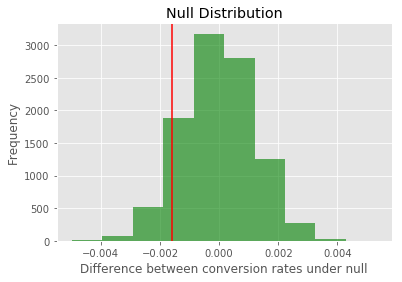

In [299]:
# Histogram of the null distribution
observation_mean = treatment_conv_prob - control_conv_prob

plt.hist(p_diffs, alpha=0.6, color='green')
plt.title("Null Distribution")
plt.xlabel('Difference between conversion rates under null')
plt.ylabel('Frequency')
plt.axvline(x=observation_mean, color = 'red');

Calculating the p-value as 0.90. Our results tell us that there is close to a 90% chance of finding our observed results when the null is true. At a type 1 error rate of 0.05, the ovserved result is not statistically significant and as such we <strong>cannot reject the null</strong>.

In [300]:
# Calculating p-value
p_val = (p_diffs > observation_mean).mean()
p_val

0.90300000000000002

In replace of the above method, the in-built function can be used to achieve similar results using the counts of converters from each of the pages as well as the total counts of each page.

In [301]:
# Setting variables to be used in the in-built function
convert_old = df2[(df2["landing_page"] == "old_page") & (df2["converted"] == 1)]["user_id"].count()
convert_new = df2[(df2["landing_page"] == "new_page") & (df2["converted"] == 1)]["user_id"].count()
n_old = n_old
n_new = n_new

The z-score is found to be approx. -1.31 with a p-value of 0.90.

In [302]:
# In-built z-test
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative="larger")
'''
We are using the "larger" parameter as this is a one-sided test to examine results larger 
than our observed statistic that appear in the null distribution.

'''

print(z_score, p_value)

-1.31092419842 0.905058312759


<strong>The p-value states that there is approximately a 90% chance of finding our observed statistic when the null is true. Our z-score states that our observation is approximately 1.3 standard deviations to the left of the center of the normal distribution (0). Again based on the results, statistical significance is not achieved and as such the null cannot be rejected.</strong>

<a id='regression'></a>
### Part IV - Logistic Regression

Since each row is either a conversion or no conversion, we can also perform a Logistic Regression to analyse the data.

**Logistic Regression**

The goal is to use **statsmodels** to fit the regression model specified above to determine if there is a significant difference in conversion based on which page a customer receives. <br>

To perform this analysis, an intercept columns will need to be created and a binary dummy variable column for which page each individual user receives.

The intercept column is set to 1, and the dummy variable column (ab_page) is set to 0 for users that received the old page and 1 for those that received the new page. 

In [303]:
# Creating intercept column
df2['intercept'] = 1

# Creating ab_page dummy variable column
df2['ab_page'] = 0
df2.loc[(df2["group"] == "treatment"), "ab_page" ] = 1

In [304]:
# Showing newly created columns
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [305]:
# Instantiating and fitting the model.
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [306]:
# Results of regression analysis
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 16 Dec 2017   Pseudo R-squ.:               8.077e-06
Time:                        18:41:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

<strong>Above is a summary of the analysis. The z-value is the same as achieved above using the in-built z-test, however the p-value has decreased dramatically. This is because Logistic Regression is simply testing to see if there is a difference between the two and as such it is a two-tail test. The p-value of 0.19 is still not statistically significant given a Type I error rate of 0.05 and as such we are not able to reject the null hypothesis.</strong> 

Currently our analysis is only a broad look at all users and does not dig deeper and analyse in more detail. It is a good idea to consider other factors to add to the regression model as it will provide more information and without looking deeper we are at risk of Simpson's Paradox.<br>

As it stands our regression results state that there is a marginal differences based on page but it is also not statistically significant with a p-value of 0.19. Further analysis can look at if country differences exist. To do this country data is read in and joined to the existing dataframe. We must be careful when adding additional terms to the regression model as doing so can increase complexity, chance of multicollinearity and decrease the statistical power

In [307]:
# Read in and join country data
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [308]:
# Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])

In [309]:
### Fitting model and obtaining results
lm = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 16 Dec 2017   Pseudo R-squ.:               2.323e-05
Time:                        18:41:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

__ Country has not had a statistically significant effect on conversion. The differences between the countries are marginal and have p-values excluding them from statistical significance. __

<a id='conclusions'></a>
## Conclusions

__ Our results showed that there is no a statistically signficant different in conversions between the two pages or between countries. Based on the data, we fail to reject the null hypothesis. The current available data is over a period of 23 days. It is suggested (provided costs aren't high for continuing) that the experiment be continued for another 33 days to determine if there are weekly changes to conversion over an 8 week period. This may provide insight into whether change related biases are at play. __
